dropout, bn, 自定义图片数据集. 

迁移学习. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os

# 导入数据及数据处理

In [2]:
base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [3]:
filenames = os.listdir('./dataset')

In [4]:
len(filenames)

1132

In [ ]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

# 创建train和test目录
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
# 分别在train和test目录下创建4种类别的目录
for train_or_test in ['train', 'test']:
    for spec in species:
        path = os.path.join(base_dir, train_or_test, spec)
        os.mkdir(path)  
# python中的自带的拷贝工具
import shutil
# 要判断一个图片属于哪个类别.
'cloudy' in img
# 要把dataset中的图片全部拷贝到train, test目录下的4个子目录中. 
for i, img in enumerate(filenames):
    for spec in species:
        if spec in img:
            img_path = os.path.join(base_dir, img)
            if i % 5 == 0:
                path = os.path.join(base_dir, 'test', spec, img)
            else: 
                path = os.path.join(base_dir, 'train', spec, img)
            shutil.copy(img_path, path)

In [6]:
species = ['cloudy', 'rain', 'shine', 'sunrise']
# 打印每个类别训练数据和测试数据分别有多少图片
for train_or_test in ['train', 'test']:
    for spec in species:
        print(train_or_test, spec, len(os.listdir(os.path.join(base_dir, train_or_test, spec))))

train cloudy 240
train rain 172
train shine 202
train sunrise 286
test cloudy 60
test rain 43
test shine 51
test sunrise 71


# 数据增强

In [7]:
from torchvision import transforms

In [8]:
transform = transforms.Compose([
    # 统一缩放到96 * 96
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    # 正则化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=transform)

In [10]:
train_ds

Dataset ImageFolder
    Number of datapoints: 900
    Root location: ./dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [11]:
test_ds = torchvision.datasets.ImageFolder(test_dir, transform=transform)

In [12]:
train_ds.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [13]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [14]:
len(train_ds)

900

In [15]:
len(test_ds)

225

In [16]:
batch_size = 32

In [17]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, )
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

In [18]:
imgs, labels = next(iter(train_dl))
imgs.shape
labels

tensor([1, 2, 3, 0, 1, 3, 2, 0, 0, 0, 0, 3, 1, 2, 0, 2, 3, 3, 1, 0, 0, 2, 0, 3,
        1, 1, 3, 2, 3, 0, 0, 1])

In [19]:
# 显示一张图片
img = imgs[0]

In [20]:
img.shape

torch.Size([3, 96, 96])

In [21]:
display(img.max(),img.min())

tensor(0.9843)

tensor(-0.9765)

In [22]:
img = img + 1
img = img / 2
display(img.max(),img.min())

tensor(0.9922)

tensor(0.0118)

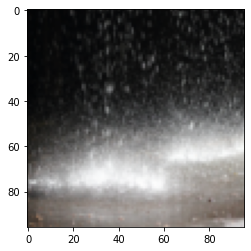

In [23]:
# reshape不可以, 会打乱数据. 
plt.imshow(img.permute(1, 2, 0))

# 定义模型

In [24]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)   # 16 * 94 * 94
        self.pool = nn.MaxPool2d(2, 2)     # 16 * 47 * 47
        self.conv2 = nn.Conv2d(16, 32, 3)  # 32 * 45 * 45  -> pooling -> 32 * 22 * 22
        self.conv3 = nn.Conv2d(32, 64, 3)  # 64 * 20 * 20  -> pooling -> 64 * 10 * 10
        self.dropout = nn.Dropout()
        
        # batch , channel, height, width, 64, 
        self.fc1 = nn.Linear(64 * 10 * 10, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x.view(-1, 64 * 10 * 10)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
model = Net()
# 把model拷到gpu上
if torch.cuda.is_available():
    model.to(device)

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [28]:
def fit(epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0
    
    # 因为bn和dropout需要手动指定训练模式和推理模式
    model.train()
    for x, y in train_loader:
        # 把数据放到GPU上去. 
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
        
    # 测试过程
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / test_total

    print('epoch: ', epoch,
         'loss: ', round(epoch_loss, 3),
         'accuracy: ', round(epoch_acc, 3),
         'test_loss: ', round(test_epoch_loss, 3),
         'test_accuracy: ', round(test_epoch_acc, 3))
    return epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc

# 模型训练

In [29]:
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

epoch:  0 loss:  0.031 accuracy:  0.567 test_loss:  0.022 test_accuracy:  0.778
epoch:  1 loss:  0.017 accuracy:  0.789 test_loss:  0.017 test_accuracy:  0.809
epoch:  2 loss:  0.016 accuracy:  0.8 test_loss:  0.016 test_accuracy:  0.827
epoch:  3 loss:  0.014 accuracy:  0.836 test_loss:  0.019 test_accuracy:  0.8
epoch:  4 loss:  0.012 accuracy:  0.848 test_loss:  0.016 test_accuracy:  0.867
epoch:  5 loss:  0.01 accuracy:  0.891 test_loss:  0.015 test_accuracy:  0.884
epoch:  6 loss:  0.01 accuracy:  0.902 test_loss:  0.014 test_accuracy:  0.867
epoch:  7 loss:  0.008 accuracy:  0.909 test_loss:  0.014 test_accuracy:  0.876
epoch:  8 loss:  0.007 accuracy:  0.919 test_loss:  0.014 test_accuracy:  0.871
epoch:  9 loss:  0.006 accuracy:  0.931 test_loss:  0.018 test_accuracy:  0.88


# 添加BN层.

In [30]:
# 添加BN层.
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)   # 16 * 94 * 94
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)     # 16 * 47 * 47
        
        self.conv2 = nn.Conv2d(16, 32, 3)  # 32 * 45 * 45  -> pooling -> 32 * 22 * 22
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)  # 64 * 20 * 20  -> pooling -> 64 * 10 * 10
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout()
        
        # batch , channel, height, width, 64, 
        self.fc1 = nn.Linear(64 * 10 * 10, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        # x.view(-1, 64 * 10 * 10)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [31]:
model = Net()
# 把model拷到gpu上
if torch.cuda.is_available():
    model.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()



In [32]:
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

epoch:  0 loss:  0.019 accuracy:  0.777 test_loss:  0.017 test_accuracy:  0.831
epoch:  1 loss:  0.012 accuracy:  0.85 test_loss:  0.016 test_accuracy:  0.827
epoch:  2 loss:  0.011 accuracy:  0.878 test_loss:  0.013 test_accuracy:  0.858
epoch:  3 loss:  0.009 accuracy:  0.904 test_loss:  0.013 test_accuracy:  0.871
epoch:  4 loss:  0.007 accuracy:  0.914 test_loss:  0.013 test_accuracy:  0.84
epoch:  5 loss:  0.007 accuracy:  0.937 test_loss:  0.014 test_accuracy:  0.827
epoch:  6 loss:  0.01 accuracy:  0.908 test_loss:  0.013 test_accuracy:  0.876
epoch:  7 loss:  0.007 accuracy:  0.93 test_loss:  0.011 test_accuracy:  0.898
epoch:  8 loss:  0.009 accuracy:  0.927 test_loss:  0.012 test_accuracy:  0.898
epoch:  9 loss:  0.007 accuracy:  0.907 test_loss:  0.011 test_accuracy:  0.898


In [33]:
torch.save(model.state_dict(), './my_model.pth')

In [34]:
# 恢复模型
new_model = Net()

In [35]:
new_model.load_state_dict(torch.load('./my_model.pth'))

<All keys matched successfully>

In [36]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-5.0490e-02, -2.3826e-02, -2.0398e-02],
                        [-8.5173e-02, -3.1594e-02, -1.6557e-01],
                        [-8.2005e-02,  1.6477e-01, -8.4733e-02]],
              
                       [[ 8.7277e-02, -7.2264e-02,  8.1555e-02],
                        [ 4.3290e-02,  1.7002e-01, -7.0736e-02],
                        [ 1.7102e-01, -4.7538e-03,  1.6747e-01]],
              
                       [[ 8.2561e-02,  4.1792e-02,  1.8187e-02],
                        [-1.5068e-01,  3.1735e-02,  3.4933e-02],
                        [-1.0650e-01,  1.5443e-01,  1.3766e-01]]],
              
              
                      [[[ 8.4245e-02, -1.6533e-02,  1.7104e-01],
                        [ 7.4645e-02, -4.4103e-02,  4.3816e-03],
                        [ 3.2145e-02,  2.4146e-02, -9.0166e-02]],
              
                       [[ 1.6859e-01, -1.7431e-02, -1.1115e-02],
                        [-7.0588e-02, -7.8593

In [37]:
# 把新的模型拷到GPU上, 进行测试
new_model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [38]:
test_correct = 0
test_total = 0
new_model.eval()
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        y_pred = new_model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
        
epoch_test_acc = test_correct / test_total
print(epoch_test_acc)

0.8977777777777778


# 保存最优参数

In [39]:
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
import copy

In [41]:
# 没有训练之前的初始化参数, 
best_model_weight = model.state_dict()

best_acc = 0.0

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        # 更新参数
        best_model_weight = copy.deepcopy(model.state_dict())

epoch:  0 loss:  0.019 accuracy:  0.752 test_loss:  0.022 test_accuracy:  0.791
epoch:  1 loss:  0.013 accuracy:  0.873 test_loss:  0.013 test_accuracy:  0.844
epoch:  2 loss:  0.011 accuracy:  0.883 test_loss:  0.01 test_accuracy:  0.898
epoch:  3 loss:  0.009 accuracy:  0.914 test_loss:  0.01 test_accuracy:  0.911
epoch:  4 loss:  0.013 accuracy:  0.883 test_loss:  0.01 test_accuracy:  0.907
epoch:  5 loss:  0.01 accuracy:  0.9 test_loss:  0.01 test_accuracy:  0.898
epoch:  6 loss:  0.008 accuracy:  0.92 test_loss:  0.01 test_accuracy:  0.907
epoch:  7 loss:  0.007 accuracy:  0.93 test_loss:  0.01 test_accuracy:  0.907
epoch:  8 loss:  0.005 accuracy:  0.953 test_loss:  0.009 test_accuracy:  0.924
epoch:  9 loss:  0.005 accuracy:  0.946 test_loss:  0.013 test_accuracy:  0.884


In [42]:
# 把最好的参数加载到模型中
model.load_state_dict(best_model_weight)

<All keys matched successfully>

# 保存完整模型

In [43]:
torch.save(model, './my_whole_model.pth')

In [44]:
new_model2 = torch.load('./my_whole_model.pth')

In [45]:
new_model2.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1688,  0.0020,  0.0588],
                        [-0.1473, -0.1037,  0.0517],
                        [-0.0465,  0.0127,  0.0309]],
              
                       [[ 0.1539, -0.0771,  0.0568],
                        [ 0.1002,  0.1681, -0.1553],
                        [-0.0187,  0.0927, -0.1776]],
              
                       [[ 0.0468, -0.0292, -0.1084],
                        [ 0.0622, -0.0376,  0.0757],
                        [-0.2033, -0.1791,  0.1090]]],
              
              
                      [[[ 0.1897, -0.0275,  0.2159],
                        [ 0.0043,  0.1284, -0.0364],
                        [-0.1094,  0.0183,  0.0899]],
              
                       [[-0.0385,  0.0560,  0.1802],
                        [ 0.1124, -0.0215,  0.1594],
                        [-0.1766,  0.0224, -0.1268]],
              
                       [[-0.0180, -0.0013, -0.0190],
                        [ 

In [46]:
new_model2

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [47]:
# 把新的模型拷到GPU上, 进行测试
new_model2.to(device)
test_correct = 0
test_total = 0
new_model2.eval()
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        y_pred = new_model2(x)
        y_pred = torch.argmax(y_pred, dim=1)
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
        
epoch_test_acc = test_correct / test_total
print(epoch_test_acc)

0.9244444444444444


# 跨设备的模型保存和加载

In [48]:
device

device(type='cpu')

In [49]:
torch.save(model.state_dict(), './my_best_weight')

In [50]:
# 把刚才保存的模型映射到GPU上去. 
model = Net()
# 相当于加载完模型后, 执行了model.to(device)
model.load_state_dict(torch.load('./my_best_weight', map_location=device))

<All keys matched successfully>

In [51]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

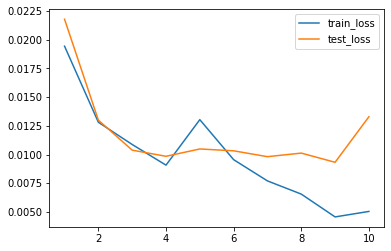

In [52]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

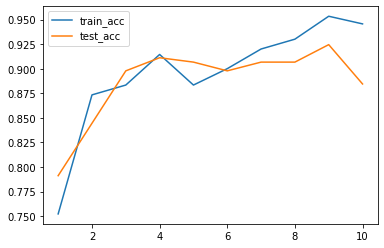

In [53]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()